# Как узнать свою аудиторию? Построение различных вариантов кластеризаций и интерпретация результатов.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install umap-learn

# Часть 1. EDA

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import norm
from tqdm import tqdm


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
import umap
from sklearn.manifold import TSNE

%matplotlib inline

plt.rcParams["figure.figsize"] = (12,8)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
data = pd.read_csv('/content/drive/MyDrive/STUDY/otus/HW/4/german_credit_data.csv')

In [5]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [6]:
data.describe()

,Unnamed: 0,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,35.546000,1.904000,3271.258000,20.903000
std,288.819436,11.375469,0.653614,2822.736876,12.058814
min,0.000000,19.000000,0.000000,250.000000,4.000000
25%,249.750000,27.000000,2.000000,1365.500000,12.000000
50%,499.500000,33.000000,2.000000,2319.500000,18.000000
75%,749.250000,42.000000,2.000000,3972.250000,24.000000
max,999.000000,75.000000,3.000000,18424.000000,72.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


проверка на пропуски

In [8]:
data.isnull().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

### Unnamed: 0

удалим неинформативный признак Unnamed: 0	

In [9]:
del data['Unnamed: 0']

In [10]:
df = data.copy()

In [11]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


### Age

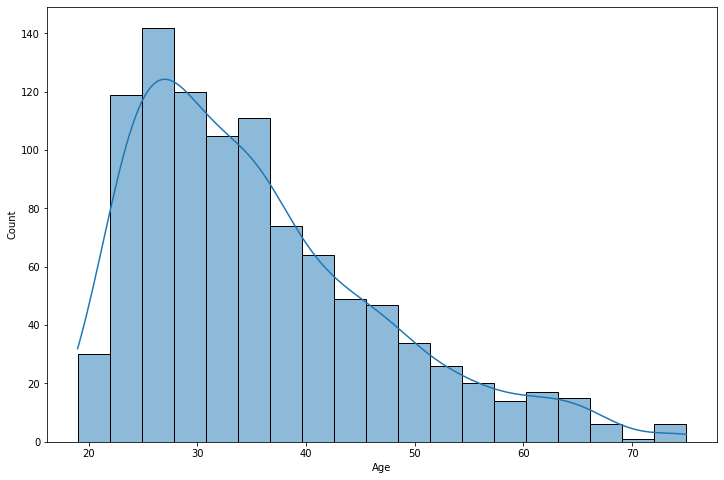

In [12]:
sns.histplot(data=df, x="Age", kde=True)

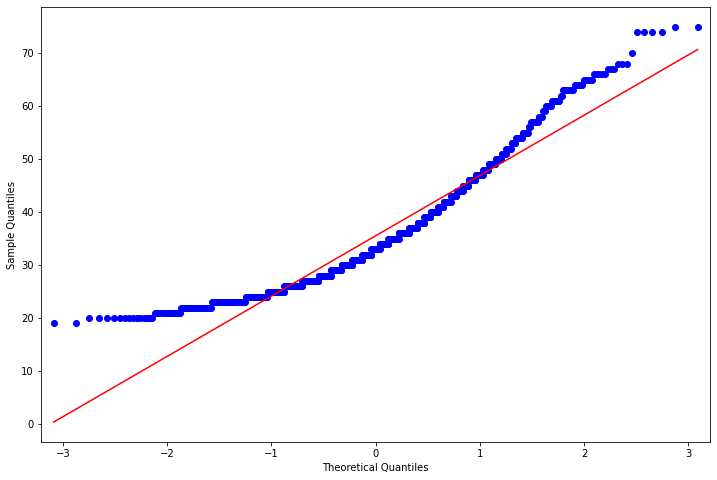

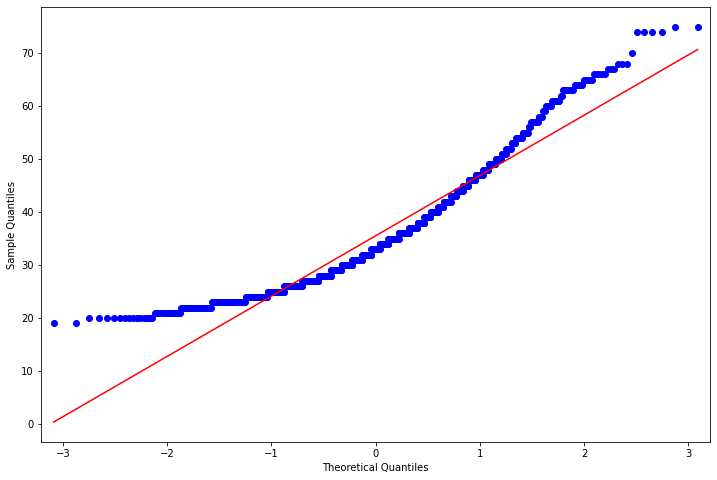

In [13]:
qqplot(df.Age, line='s')

переменная в целом похожа на нормальное распределение, оставляем как есть

### Sex

In [14]:
df.Sex.value_counts()

male      690
female    310
Name: Sex, dtype: int64

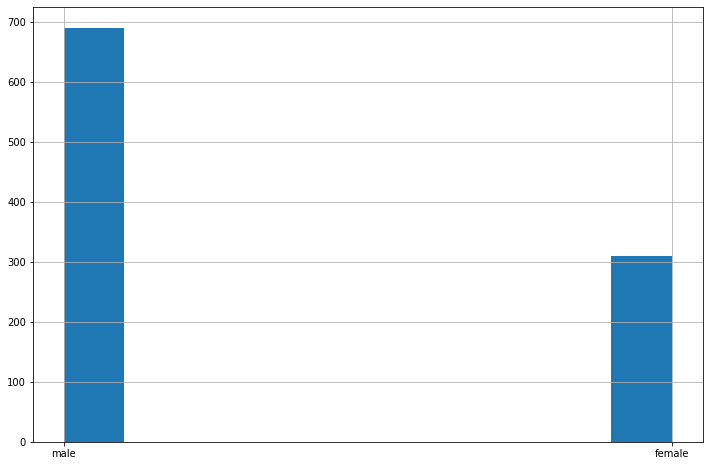

In [15]:
df.Sex.hist()

применим one-hot-encoding

In [16]:
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)

### Job

In [17]:
df.Job.value_counts()

2    630
1    200
3    148
0     22
Name: Job, dtype: int64

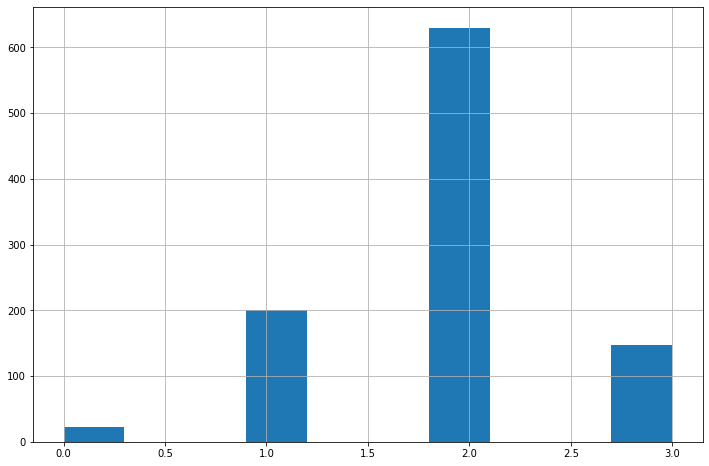

In [18]:
df.Job.hist()

оставим данную переменную как есть,т.к. Job = 3 вроде как означает highlyskilled, 0 - unskilled and non-resident по информации из kaggle ноутбуков

### Housing

In [19]:
df.Housing.value_counts()

own     713
rent    179
free    108
Name: Housing, dtype: int64

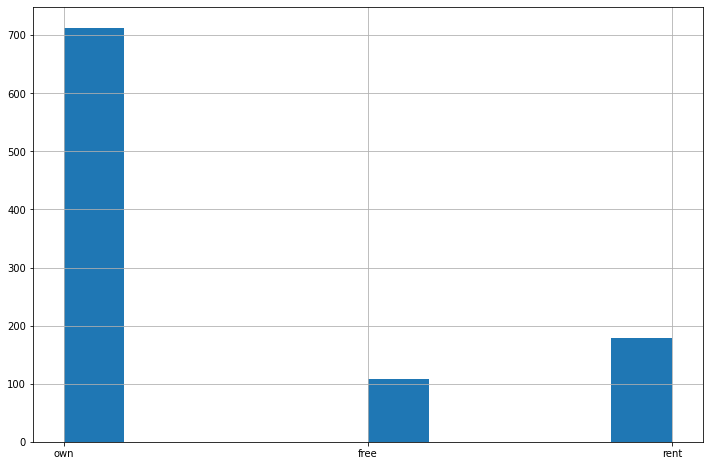

In [20]:
df.Housing.hist()

применим ohe

In [21]:
df = pd.get_dummies(df, columns=['Housing'], drop_first=True)

In [22]:
df.head()

,Age,Job,Saving accounts,Checking account,Credit amount,Duration,Purpose,Sex_male,Housing_own,Housing_rent
0,67,2,NaN,little,1169,6,radio/TV,1,1,0
1,22,2,little,moderate,5951,48,radio/TV,0,1,0
2,49,1,little,NaN,2096,12,education,1,1,0
3,45,2,little,little,7882,42,furniture/equipment,1,0,0
4,53,2,little,little,4870,24,car,1,0,0


### Saving accounts

In [23]:
df['Saving accounts'].value_counts()

little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

In [24]:
df['Saving accounts'].isnull().sum()

183

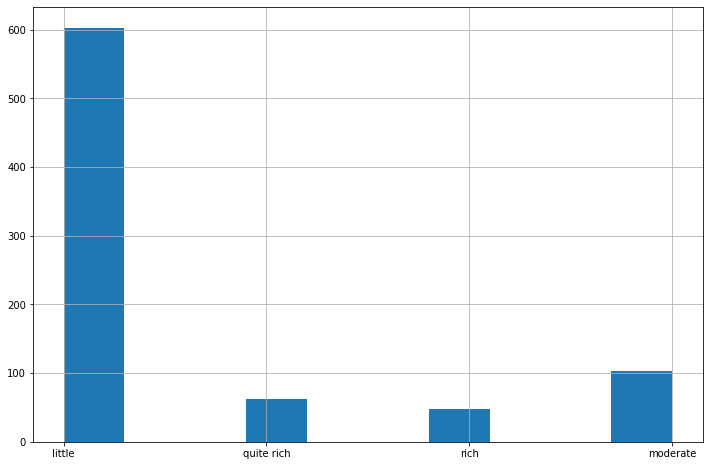

In [25]:
df['Saving accounts'].hist()

переведем строку в цифры, в данном случае rich = 4, little = 1 учитывает порядок, поэтому обойдемся без ohe

In [26]:
#data = pd.get_dummies(data, columns=['Saving accounts'], drop_first=True)
d = {'little': 0, 'moderate':1, 'quite rich': 2 , 'rich': 3}
df['Saving accounts'] = df['Saving accounts'].map(d)

In [27]:
df.head()

,Age,Job,Saving accounts,Checking account,Credit amount,Duration,Purpose,Sex_male,Housing_own,Housing_rent
0,67,2,NaN,little,1169,6,radio/TV,1,1,0
1,22,2,0.0,moderate,5951,48,radio/TV,0,1,0
2,49,1,0.0,NaN,2096,12,education,1,1,0
3,45,2,0.0,little,7882,42,furniture/equipment,1,0,0
4,53,2,0.0,little,4870,24,car,1,0,0


In [28]:
df['Saving accounts'].isnull().median()

0.0

заменим Nan на median()

In [29]:
df['Saving accounts'] = df['Saving accounts'].fillna(df['Saving accounts'].isnull().median())

### Checking account

In [30]:
df['Checking account'].value_counts()

little      274
moderate    269
rich         63
Name: Checking account, dtype: int64

поступим аналогично Saving accounts

In [31]:
d = {'little': 0, 'moderate':1, 'rich': 2}
df['Checking account'] = df['Checking account'].map(d)

In [32]:
df['Checking account'] = df['Checking account'].fillna(df['Checking account'].isnull().median())

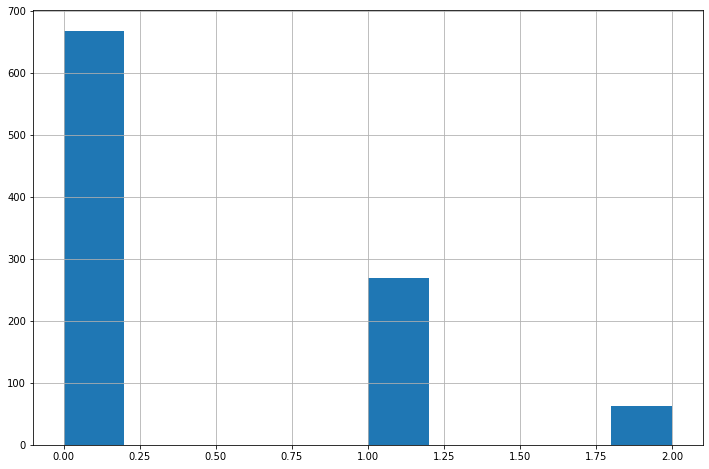

In [33]:
df['Checking account'].hist()

In [34]:
df.head()

,Age,Job,Saving accounts,Checking account,Credit amount,Duration,Purpose,Sex_male,Housing_own,Housing_rent
0,67,2,0.0,0.0,1169,6,radio/TV,1,1,0
1,22,2,0.0,1.0,5951,48,radio/TV,0,1,0
2,49,1,0.0,0.0,2096,12,education,1,1,0
3,45,2,0.0,0.0,7882,42,furniture/equipment,1,0,0
4,53,2,0.0,0.0,4870,24,car,1,0,0


### Credit amount

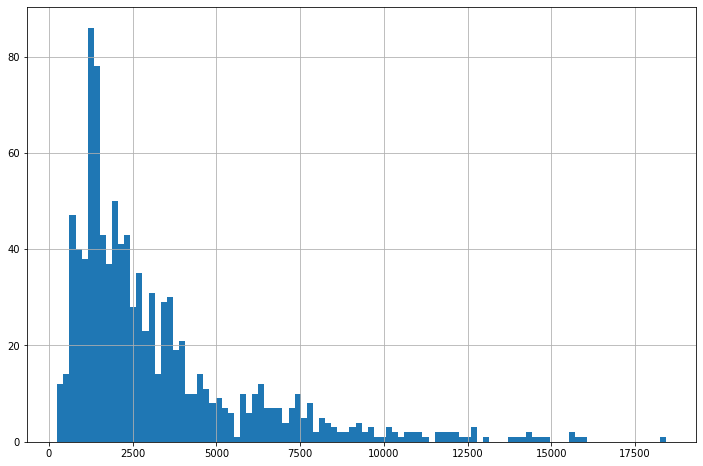

In [35]:
df['Credit amount'].hist(bins = 100)

смещено влево, попробуем пролагорифмировать, чтобы сделать нормальным

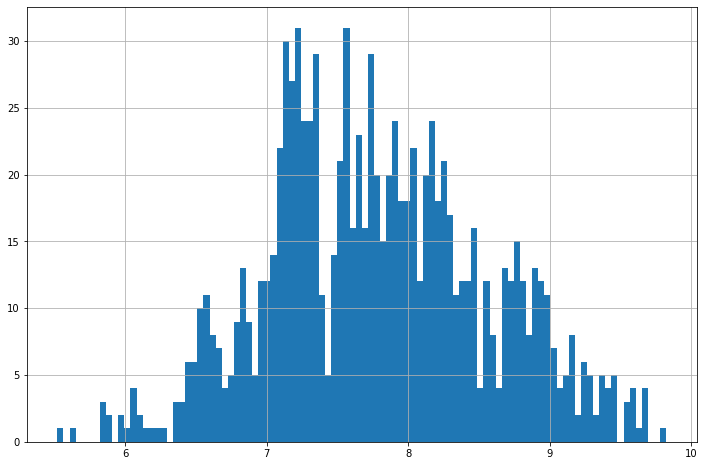

In [36]:
np.log(df['Credit amount']).hist(bins = 100)

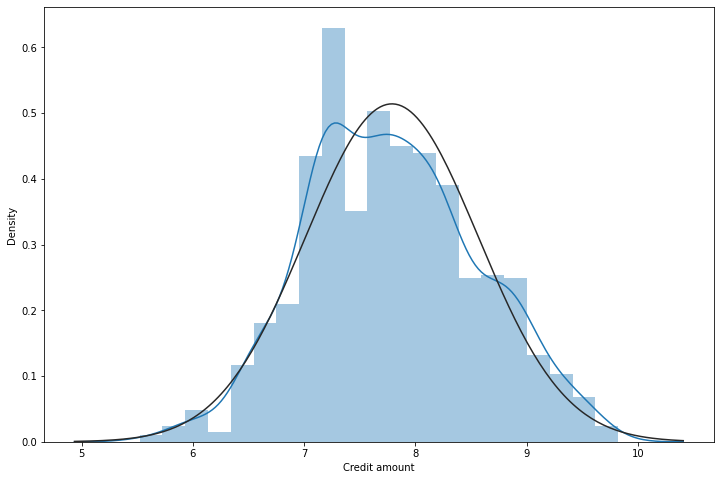

In [37]:
sns.distplot(np.log(df['Credit amount']), fit=norm)

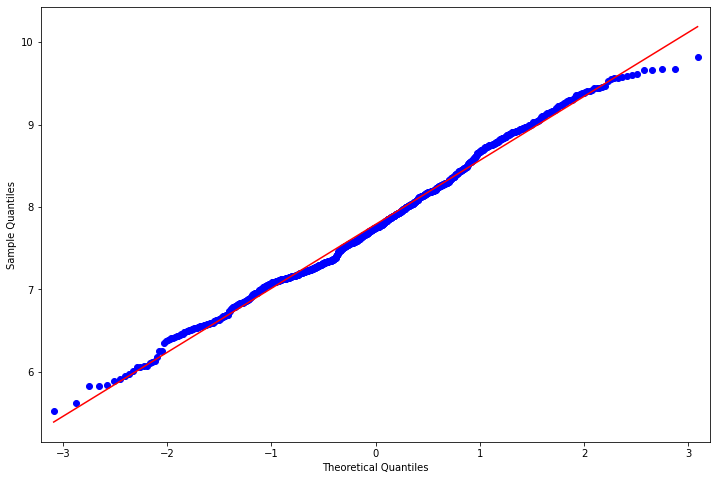

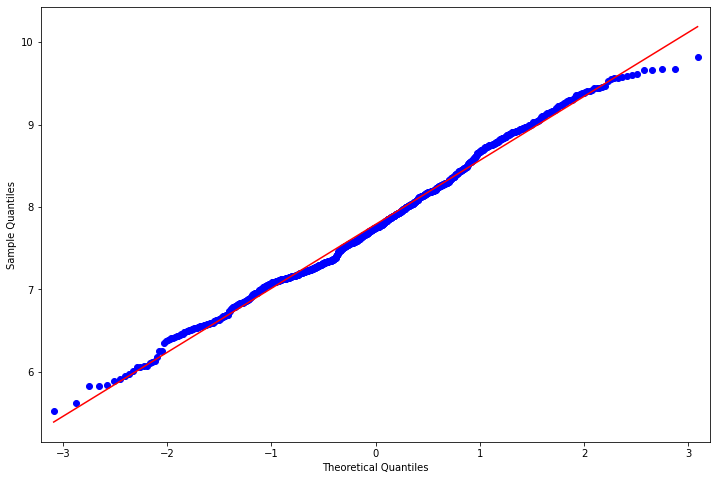

In [38]:
qqplot(np.log(df['Credit amount']), line='s')

ок, логарифмируем

In [39]:
df['Credit amount'] = np.log(df['Credit amount'])

### Duration

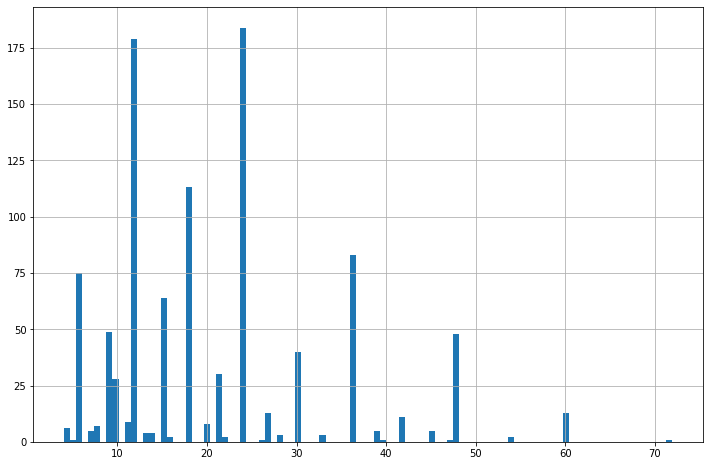

In [40]:
df.Duration.hist(bins = 100)

In [41]:
df.Duration.value_counts()

24    184
12    179
18    113
36     83
6      75
15     64
9      49
48     48
30     40
21     30
10     28
27     13
60     13
42     11
11      9
20      8
8       7
4       6
39      5
45      5
7       5
14      4
13      4
33      3
28      3
22      2
16      2
54      2
26      1
40      1
47      1
5       1
72      1
Name: Duration, dtype: int64

### Purpose 

In [42]:
df.Purpose.value_counts()

car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Purpose, dtype: int64

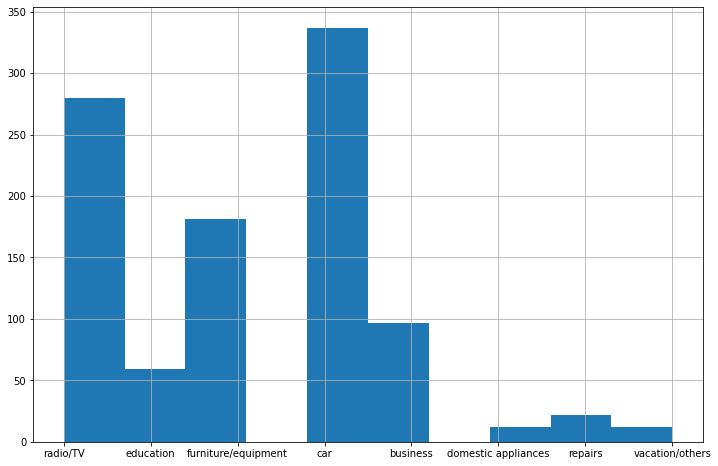

In [43]:
df.Purpose.hist()

применим частотное кодирование

In [44]:
df['Purpose'] = df['Purpose'].map(df['Purpose'].value_counts(normalize=True))

In [45]:
df.head()

,Age,Job,Saving accounts,Checking account,Credit amount,Duration,Purpose,Sex_male,Housing_own,Housing_rent
0,67,2,0.0,0.0,7.063904,6,0.280,1,1,0
1,22,2,0.0,1.0,8.691315,48,0.280,0,1,0
2,49,1,0.0,0.0,7.647786,12,0.059,1,1,0
3,45,2,0.0,0.0,8.972337,42,0.181,1,0,0
4,53,2,0.0,0.0,8.490849,24,0.337,1,0,0


### Scalling

шкалирование нам необходимо чтобы модель воспринимала данные в одном масштабе, и не было перекоса в сторону одного признака только из за того, что у него больше масштаб

In [46]:
continuous_vars = [
  'Age', 
  'Job',
  'Credit amount',
 'Duration',
]

In [47]:
scaler = StandardScaler()
df[continuous_vars] = scaler.fit_transform(df[continuous_vars])

In [48]:
df.head()

,Age,Job,Saving accounts,Checking account,Credit amount,Duration,Purpose,Sex_male,Housing_own,Housing_rent
0,2.766456,0.146949,0.0,0.0,-0.933901,-1.236478,0.280,1,1,0
1,-1.191404,0.146949,0.0,1.0,1.163046,2.248194,0.280,0,1,0
2,1.183312,-1.383771,0.0,0.0,-0.181559,-0.738668,0.059,1,1,0
3,0.831502,0.146949,0.0,0.0,1.525148,1.750384,0.181,1,0,0
4,1.535122,0.146949,0.0,0.0,0.904743,0.256953,0.337,1,0,0


### распредделения

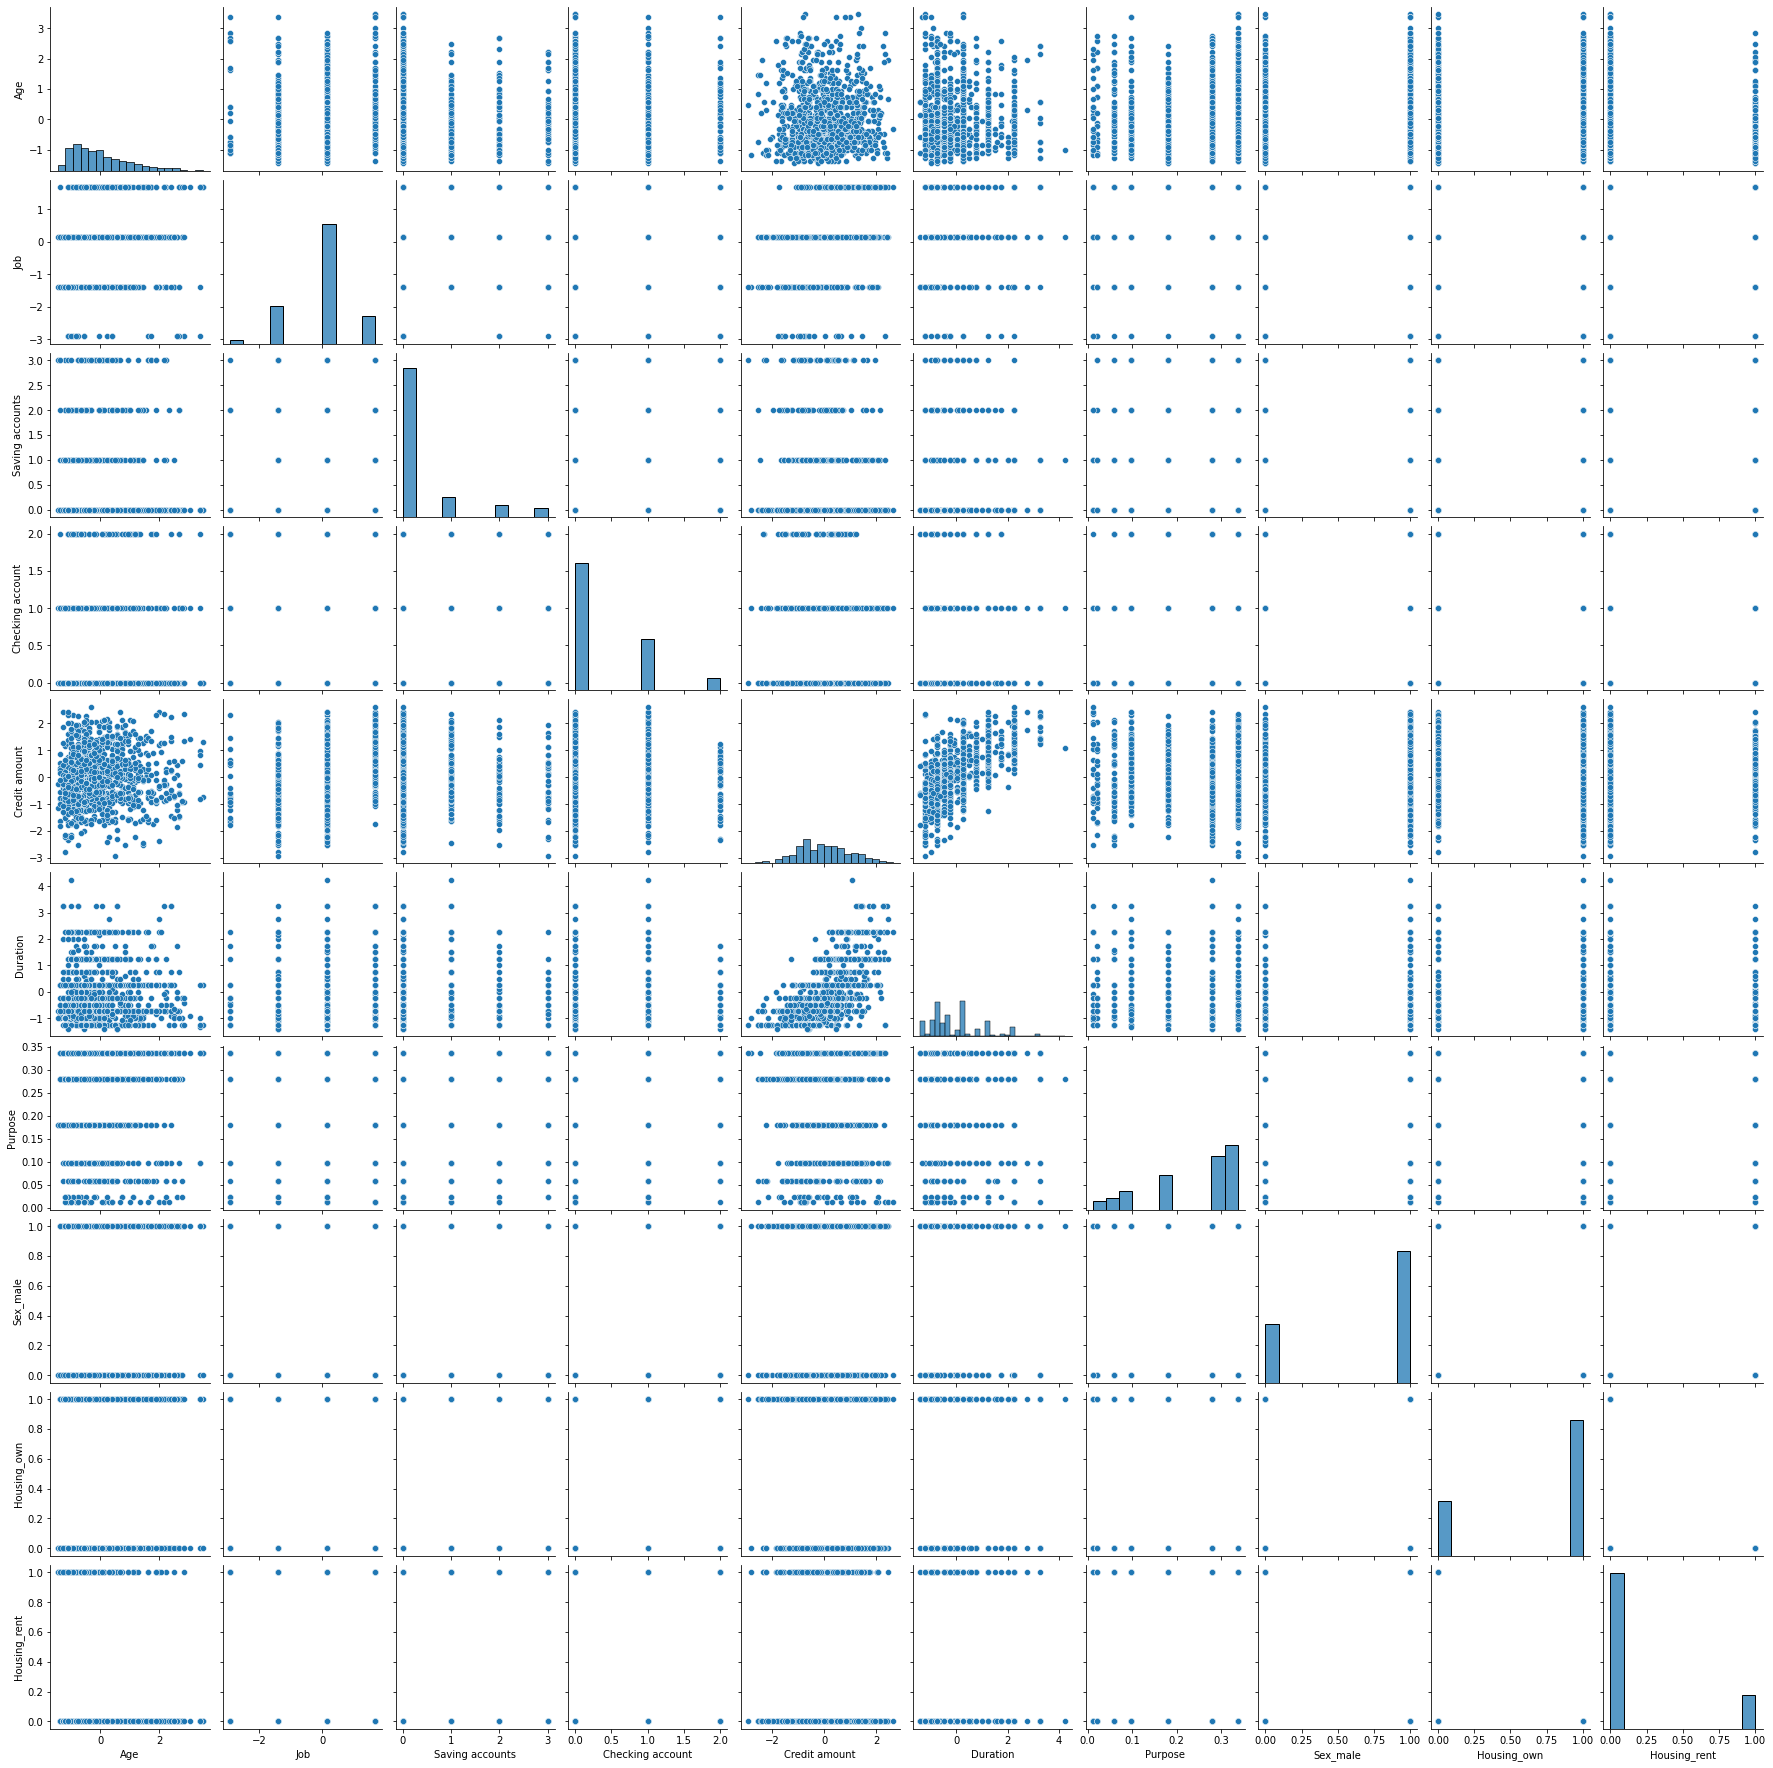

In [49]:
sns.pairplot(df)

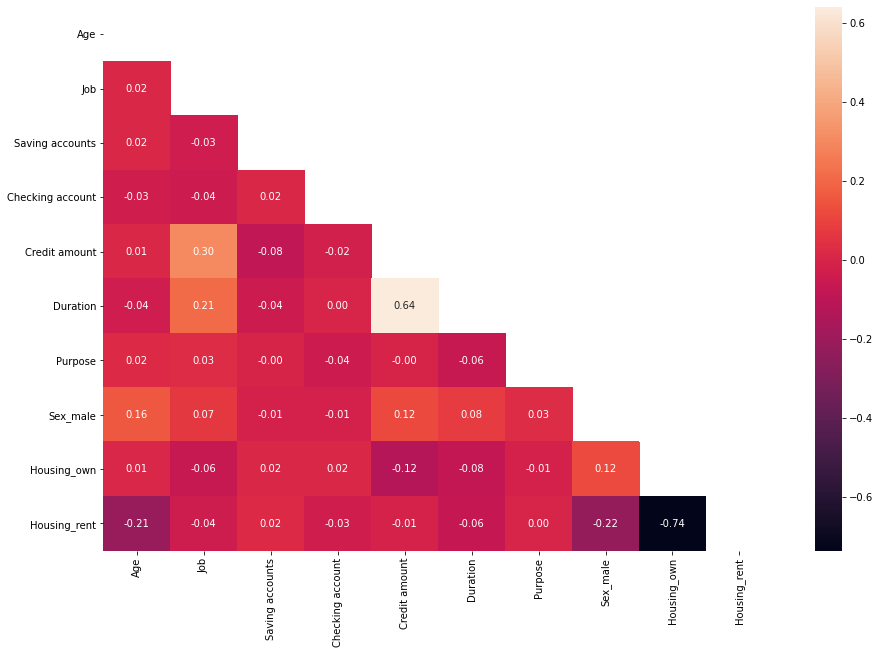

In [50]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(15,10))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f');

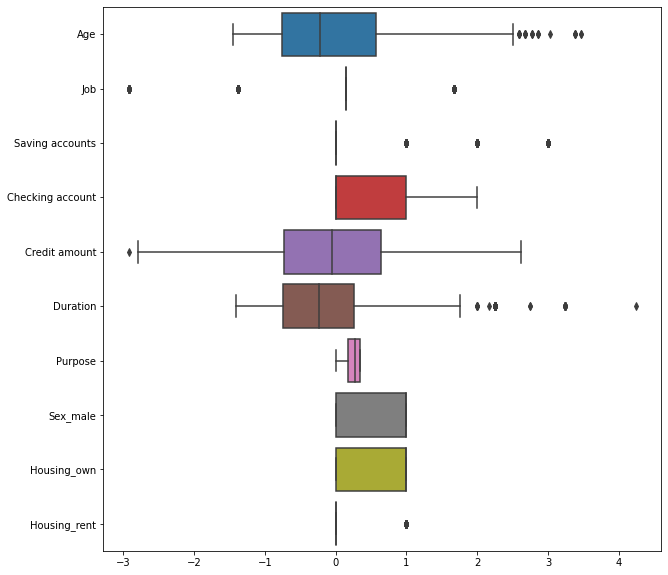

In [51]:
plt.figure(figsize=(10,10))
sns.boxplot(data=df, orient='h');

In [52]:
df.tail()

,Age,Job,Saving accounts,Checking account,Credit amount,Duration,Purpose,Sex_male,Housing_own,Housing_rent
995,-0.399832,-1.383771,0.0,0.0,-0.424376,-0.738668,0.181,0,1,0
996,0.391740,1.677670,0.0,0.0,0.604255,0.754763,0.337,1,1,0
997,0.215835,0.146949,0.0,0.0,-1.416199,-0.738668,0.280,1,1,0
998,-1.103451,0.146949,0.0,0.0,-0.345911,1.999289,0.280,1,0,0
999,-0.751642,0.146949,1.0,1.0,0.824508,1.999289,0.337,1,1,0


# Часть 2 Моделирование

### k-means

In [53]:
inertia = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=2021, n_jobs=-1).fit(df)
    labels_k = kmeans.labels_
    inertia_i = kmeans.inertia_
    inertia.append(inertia_i)

Elbow method

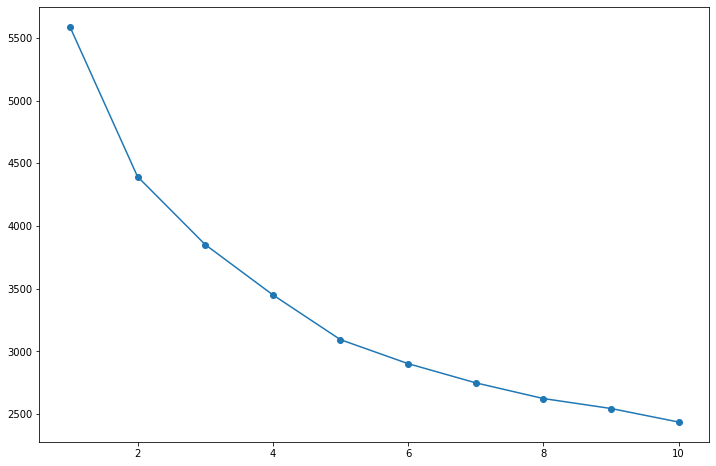

In [54]:
plt.plot(range(1,11), inertia, marker='o');

Silhouette plot

In [55]:
silhouette = []
for i in tqdm(range(2,11)):
    agg = KMeans(n_clusters=i, random_state=2021, n_jobs=-1).fit(df)
    labels_k = agg.labels_
    score = silhouette_score(df, labels_k)
    silhouette.append(score)

100%|██████████| 9/9 [00:01<00:00,  5.61it/s]


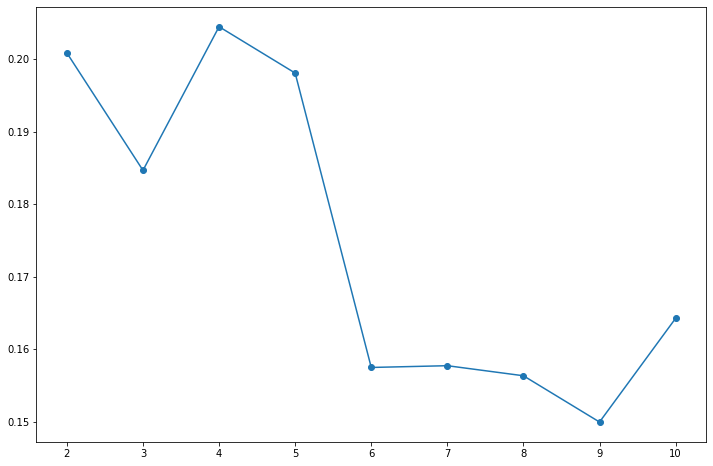

In [56]:
plt.plot(range(2,11), silhouette, marker='o');

k-means говорит о 4 кластерах

In [57]:
kmeans = KMeans(n_clusters=4, random_state=2021, n_jobs=-1).fit(df)
labels_k = kmeans.labels_

### hierarhical clustering (AgglomerativeClustering)

dendrogram метод определения кластеров

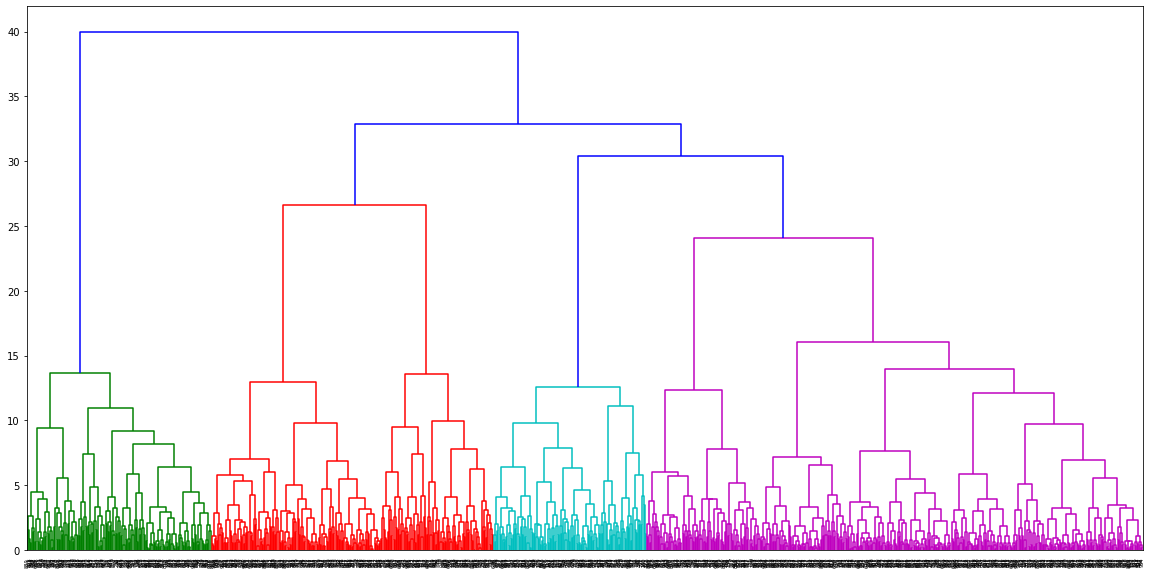

In [58]:
plt.figure(figsize=(20,10))
linkage_ = linkage(df, method='ward')
dendrogram_ = dendrogram(linkage_)

Silhouette plot

In [59]:
silhouette = []
for i in tqdm(range(2,11)):
    agg = AgglomerativeClustering(n_clusters=i).fit(df)
    labels_a = agg.labels_
    score = silhouette_score(df, labels_a)
    silhouette.append(score)

100%|██████████| 9/9 [00:00<00:00, 12.91it/s]


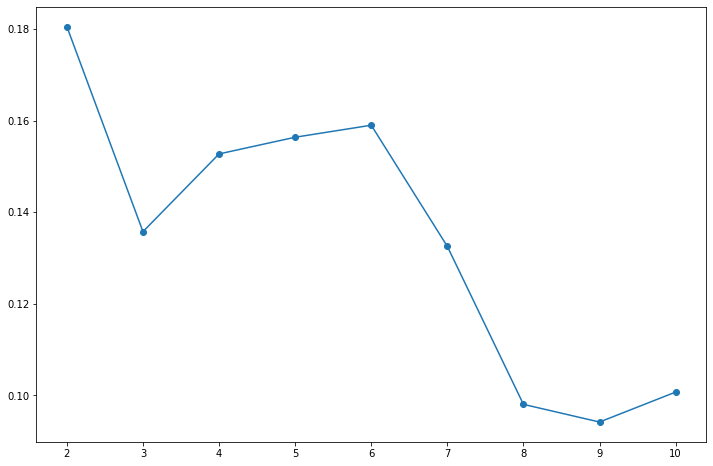

In [60]:
plt.plot(range(2,11), silhouette, marker='o');

по агломеративному - выбираем тоже 4 кластера, чтобы сравнить после снижения размерности

In [61]:
agg = AgglomerativeClustering(n_clusters=4).fit(df)
labels_a = agg.labels_

### DBSCAN

найдем подходящий eps по методу NearestNeighbors

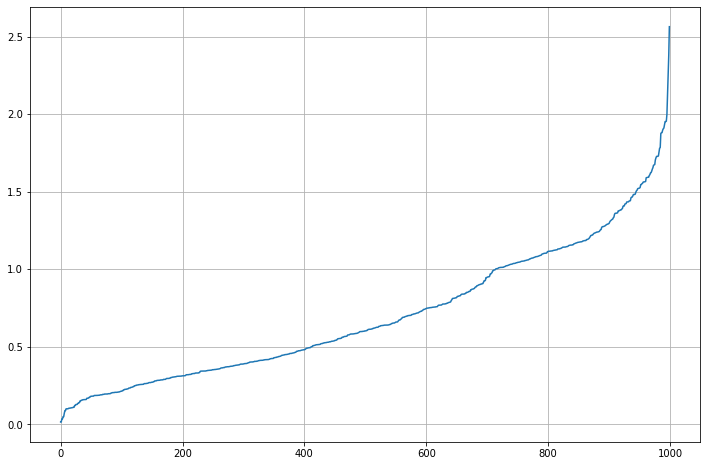

In [62]:
neighbors = NearestNeighbors(n_neighbors=5)
nbrs = neighbors.fit(df)
distance, indices = nbrs.kneighbors(df)

distance = np.sort(distance, axis=0)
distance = distance[:,1]
plt.grid()
plt.plot(distance)

возьмем eps = 1,459

```
# This is formatted as code
```



In [63]:
dbscan = DBSCAN(eps=1.459, min_samples = 4).fit(df)
labels_d = dbscan.labels_

In [64]:
myset = set(labels_d)
print(myset)

{0, 1, 2, 3, -1}


dbscan разделил на 4 кластера

### PCA

In [65]:
pca = PCA(random_state = 2021)
pca.fit(df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=2021,
    svd_solver='auto', tol=0.0, whiten=False)

объясненная дисперсия

In [66]:
np.cumsum(pca.explained_variance_ratio_)

array([0.32528197, 0.50809756, 0.65834522, 0.77363087, 0.83967005,
       0.90279593, 0.95770418, 0.99133669, 0.99814958, 1.        ])

In [67]:
df.shape

(1000, 10)

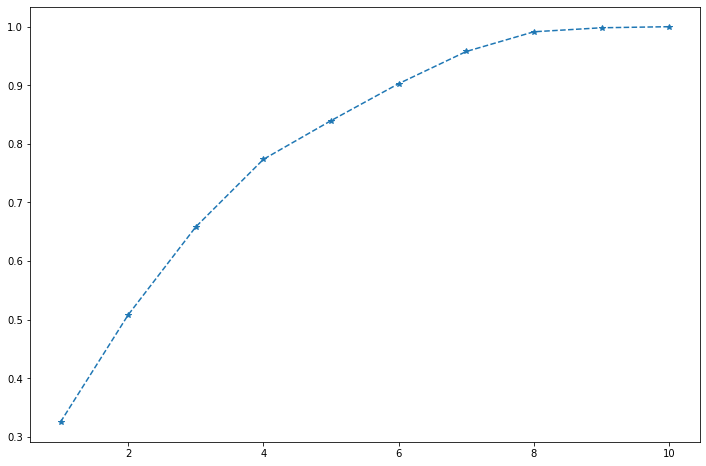

In [68]:
plt.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_), '*--');

наверно мало объясним информации методом PCA (на 2 мерном пространстве потеряем большую часть информации)

In [69]:
x_new = PCA(n_components=2).fit_transform(df)
x_new.shape

(1000, 2)

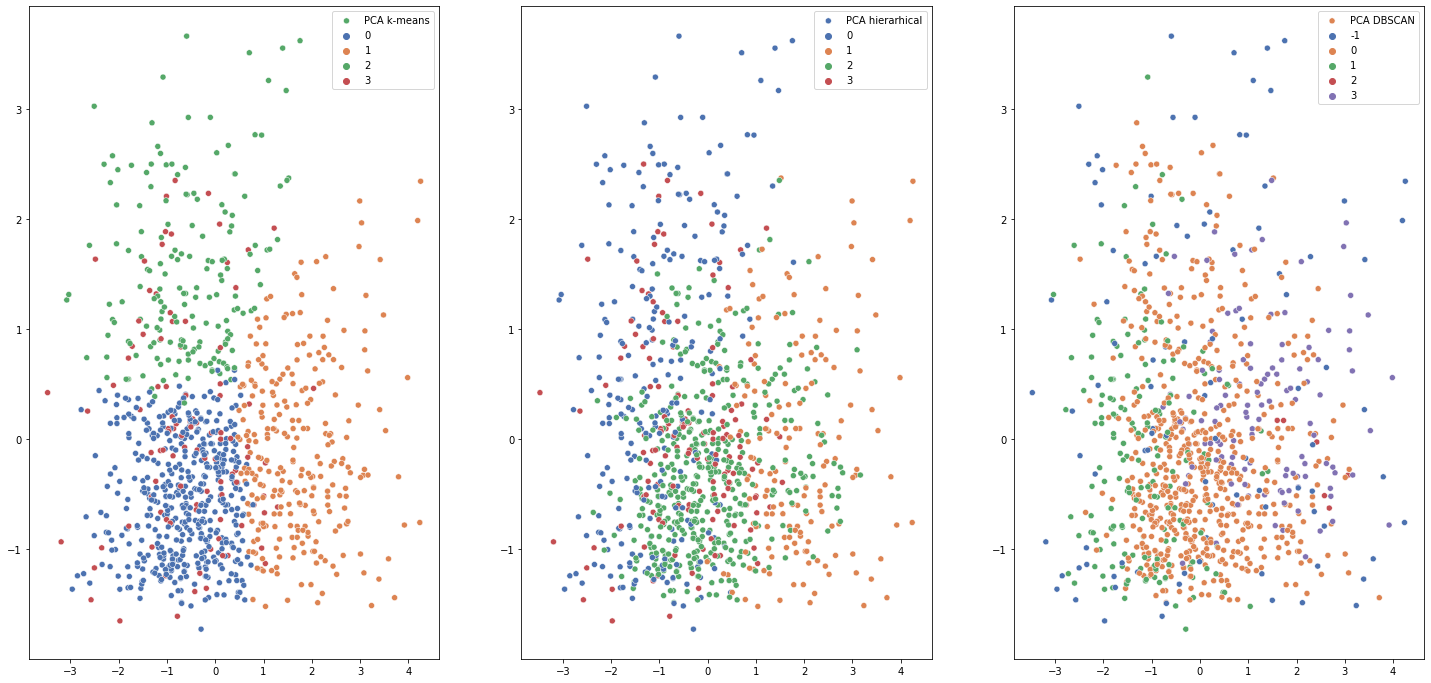

In [70]:
f, axs = plt.subplots(1,3,figsize=(25,12))
plt.subplot(1, 3, 1)
sns.scatterplot(x=x_new[:, 0], y=x_new[:, 1], hue=labels_k.astype(int),palette= 'deep',legend='full',label = 'PCA k-means').legend()
plt.subplot(1, 3, 2)
sns.scatterplot(x=x_new[:, 0], y=x_new[:, 1], hue=labels_a.astype(int),palette= 'deep',legend='full',label = 'PCA hierarhical').legend()
plt.subplot(1, 3, 3)
sns.scatterplot(x=x_new[:, 0], y=x_new[:, 1], hue=labels_d.astype(int),palette= 'deep',legend='full',label = 'PCA DBSCAN').legend()

### UMAP

In [71]:
reducer = umap.UMAP(random_state=2021)
X_UMAP = reducer.fit_transform(df)

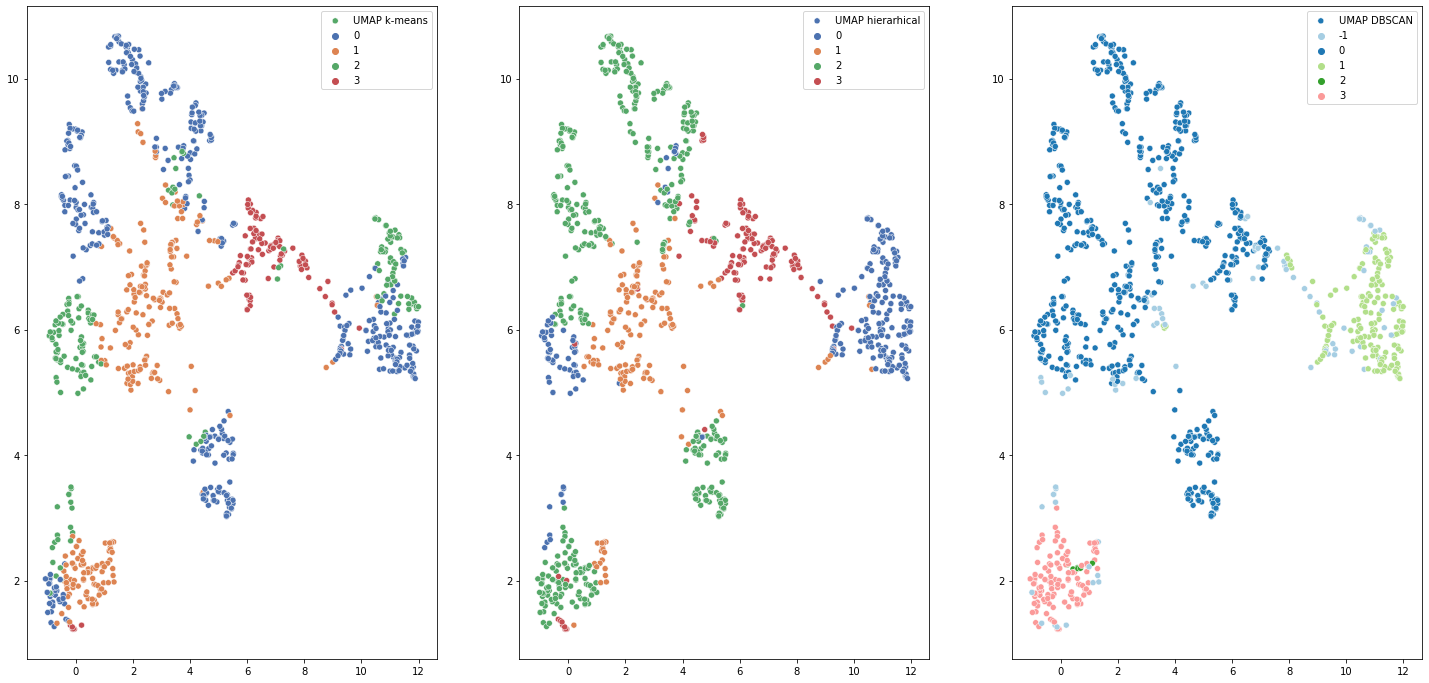

In [72]:
f, axs = plt.subplots(1,3,figsize=(25,12))
plt.subplot(1, 3, 1)
sns.scatterplot(x=X_UMAP[:, 0], y=X_UMAP[:, 1], hue=labels_k.astype(int),palette= 'deep',legend='full',label = 'UMAP k-means').legend()
plt.subplot(1, 3, 2)
sns.scatterplot(x=X_UMAP[:, 0], y=X_UMAP[:, 1], hue=labels_a.astype(int),palette= 'deep',legend='full',label = 'UMAP hierarhical').legend()
plt.subplot(1, 3, 3)
sns.scatterplot(x=X_UMAP[:, 0], y=X_UMAP[:, 1], hue=labels_d.astype(int),palette= 'Paired',legend='full',label = 'UMAP DBSCAN').legend()

### t-SNE

In [73]:
tsne = TSNE(n_components=2, random_state=2021)

In [74]:
X_tsne = tsne.fit_transform(df)

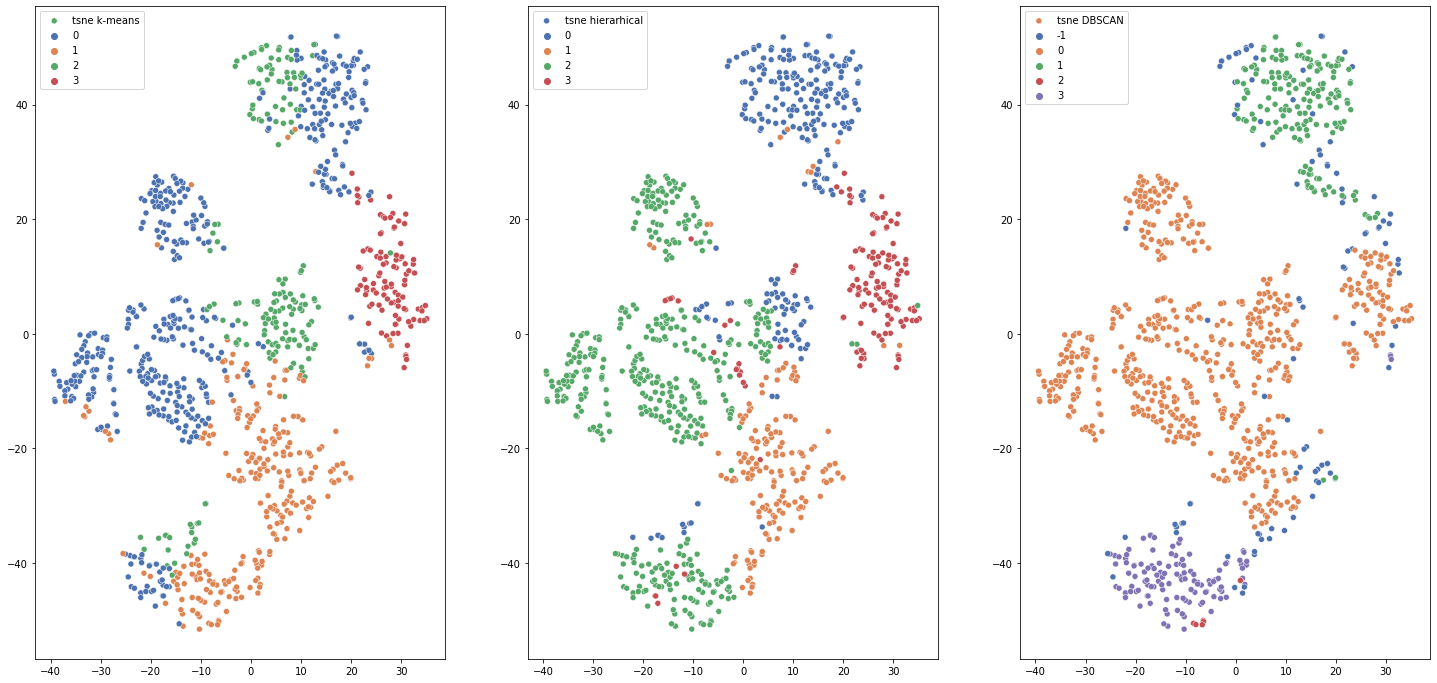

In [75]:
f, axs = plt.subplots(1,3,figsize=(25,12))
plt.subplot(1, 3, 1)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels_k.astype(int),palette= 'deep',legend='full',label = 'tsne k-means').legend()
plt.subplot(1, 3, 2)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels_a.astype(int),palette= 'deep',legend='full',label = 'tsne hierarhical').legend()
plt.subplot(1, 3, 3)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=labels_d.astype(int),palette= 'deep',legend='full',label = 'tsne DBSCAN').legend()

методом PCA хорошо визуализируется k-means

методом UMAP хорошо визуализируется иерархическая и DBSCAN

методом t-SNE хорошо визуализируется иерархическая кластеризация

# Часть 3. Интерпретация

размеры кластеров в зависимости от метода кластеризации

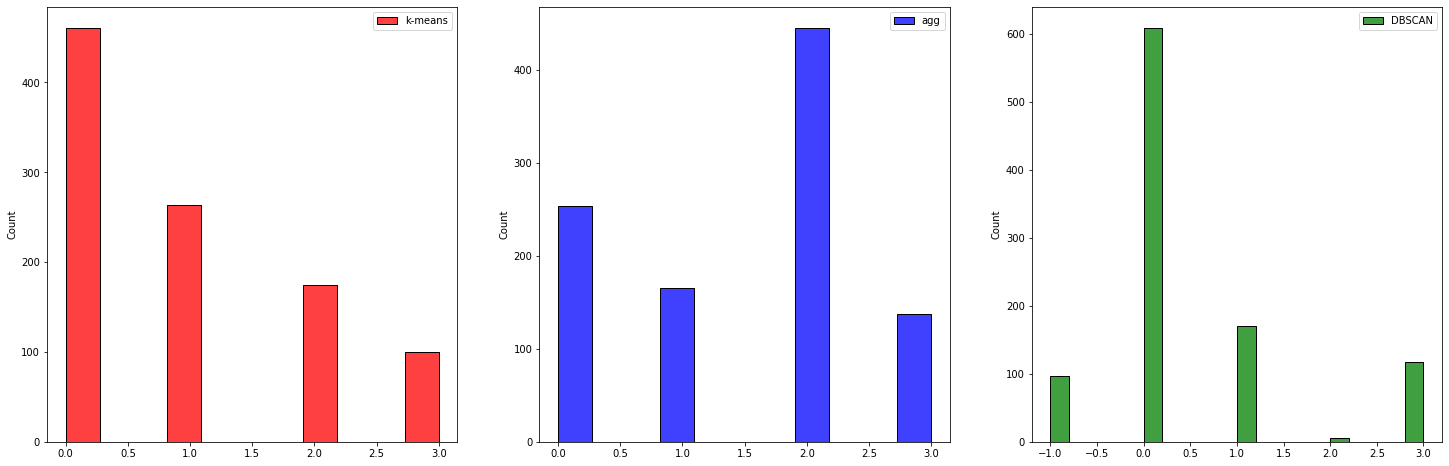

In [76]:
f, axs = plt.subplots(1,3,figsize=(25,8))
plt.subplot(1, 3, 1)
sns.histplot(x=labels_k, label = 'k-means', color = 'red').legend()
plt.subplot(1, 3, 2)
sns.histplot(x=labels_a, label = 'agg', color = 'blue').legend()
plt.subplot(1, 3, 3)
sns.histplot(x=labels_d, label = 'DBSCAN', color = 'green').legend()

chtlybt

In [77]:
data['labels_k'] = labels_k
data['labels_a'] = labels_a
data['labels_d'] = labels_d
df['labels_d'] = labels_d

In [78]:
data.groupby('labels_k').mean().T.round(2)

labels_k,0,1,2,3
Age,29.39,34.75,52.82,35.78
Job,1.77,2.26,1.76,1.85
Credit amount,2006.53,6444.50,2393.59,2260.19
Duration,15.36,35.75,15.08,17.45
labels_a,1.48,1.44,0.61,2.94
labels_d,0.41,0.78,0.30,-0.08


In [79]:
data.groupby('labels_a').mean().T.round(2)

labels_a,0,1,2,3
Age,42.72,36.07,31.30,35.47
Job,1.27,1.99,2.23,1.91
Credit amount,2083.25,6865.34,2901.16,2338.69
Duration,15.17,40.12,18.00,17.77
labels_k,0.98,1.03,0.41,2.30
labels_d,0.49,0.09,0.66,0.07


Проинтерпретируем метод DBSCAN (хорошо провизуализировался методом t-sne и UMAP)

In [80]:
data.groupby('labels_d').mean().T.round(2)

labels_d,-1,0,1,2,3
Age,43.69,34.02,35.83,32.50,36.46
Job,1.48,2.00,1.00,3.00,3.00
Credit amount,4504.53,2977.12,2148.01,7831.00,5161.92
Duration,26.11,20.95,15.01,33.33,24.25
labels_k,1.63,0.87,0.66,1.00,0.91
labels_a,1.06,1.80,0.19,1.83,1.91


In [81]:
df.groupby('labels_d').mean().T.round(2)

labels_d,-1,0,1,2,3
Age,0.72,-0.13,0.02,-0.27,0.08
Job,-0.64,0.15,-1.38,1.68,1.68
Saving accounts,0.98,0.38,0.18,0.50,0.12
Checking account,0.72,0.35,0.38,1.00,0.35
Credit amount,0.18,-0.04,-0.46,1.51,0.67
Duration,0.43,0.00,-0.49,1.03,0.28
Purpose,0.23,0.24,0.24,0.22,0.25
Sex_male,0.52,0.70,0.71,1.00,0.76
Housing_own,0.53,0.73,0.80,0.00,0.67
Housing_rent,0.28,0.17,0.18,0.83,0.12


In [82]:
data.labels_d.value_counts()

 0    609
 1    170
 3    118
-1     97
 2      6
Name: labels_d, dtype: int64

второй кластер получился очень маленьким, посмотрим на box-plot-ы

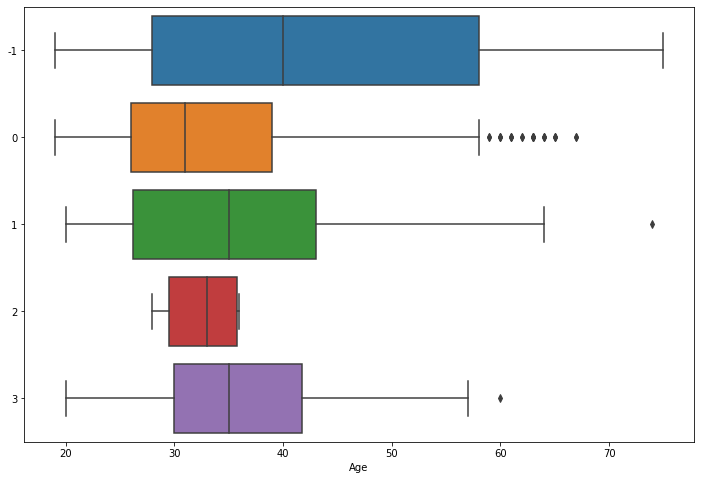

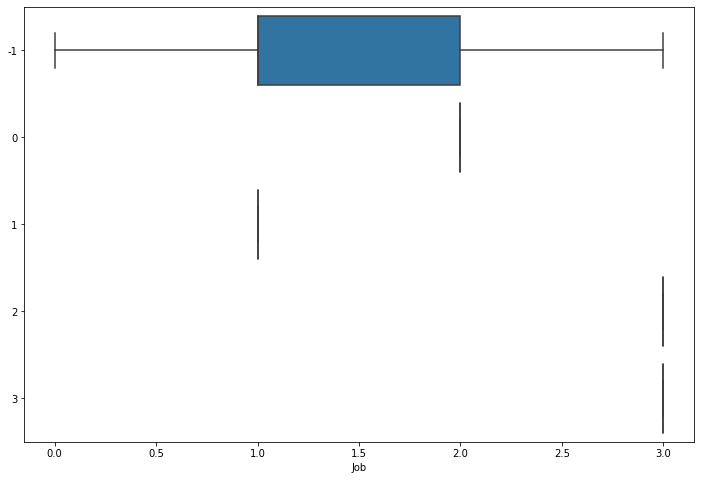

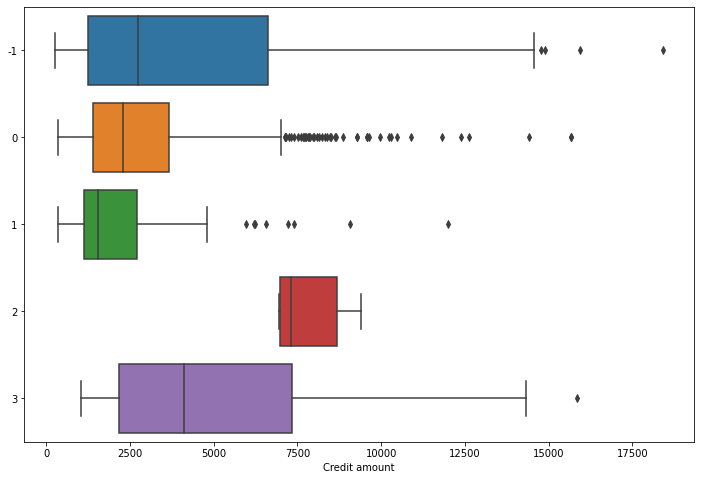

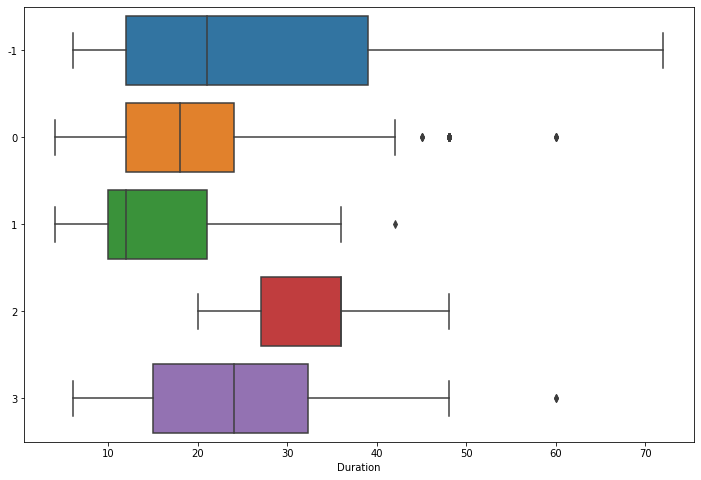

In [83]:
for col in ['Age', 'Job', 'Credit amount', 'Duration']:
    sns.boxplot(data=data, x=col, y=labels_d, orient = 'h')
    plt.show();

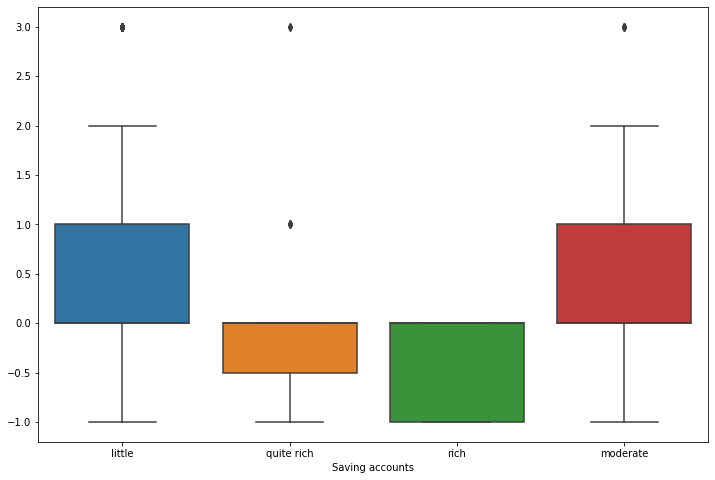

In [84]:
sns.boxplot(data=data, x='Saving accounts', y=labels_d)

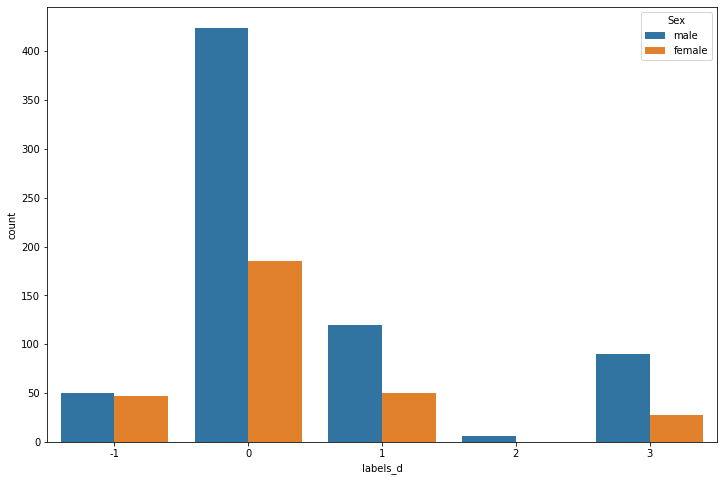

In [85]:
sns.countplot(data = data, x= 'labels_d', hue = 'Sex')

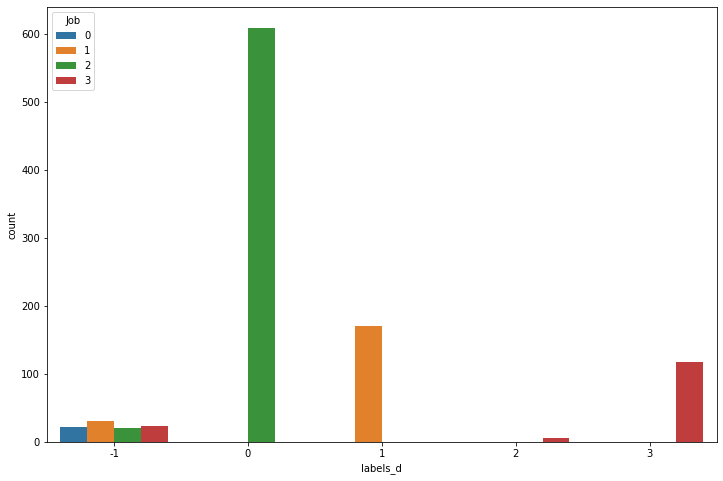

In [86]:
sns.countplot(data = data, x= 'labels_d', hue = 'Job')

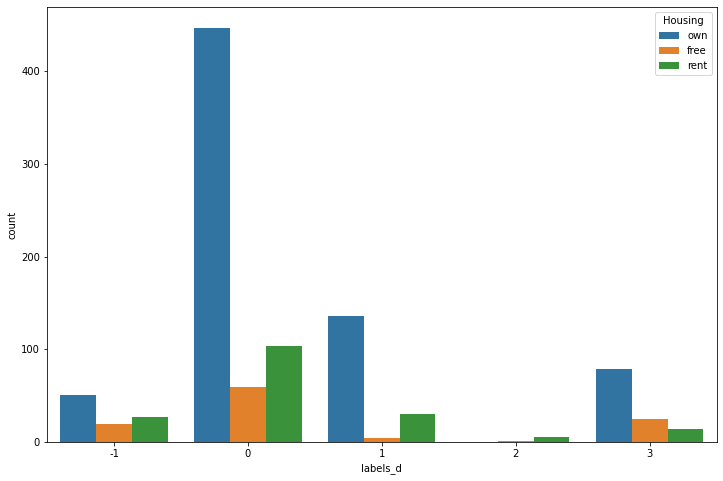

In [87]:
sns.countplot(data = data, x= 'labels_d', hue = 'Housing')

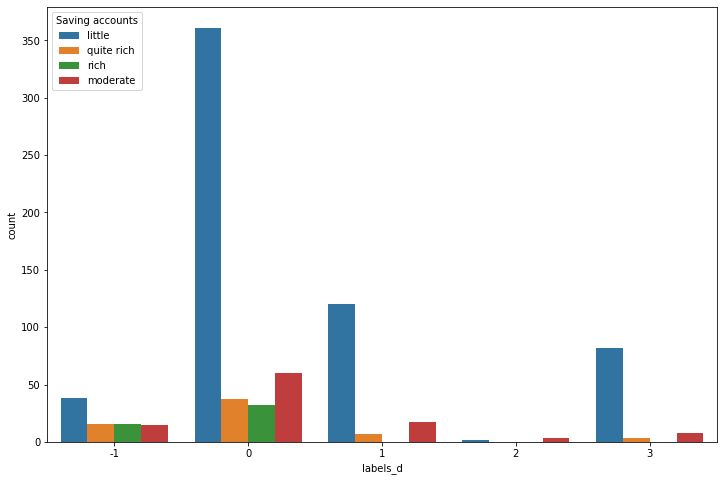

In [88]:
sns.countplot(data = data, x= 'labels_d', hue = 'Saving accounts')

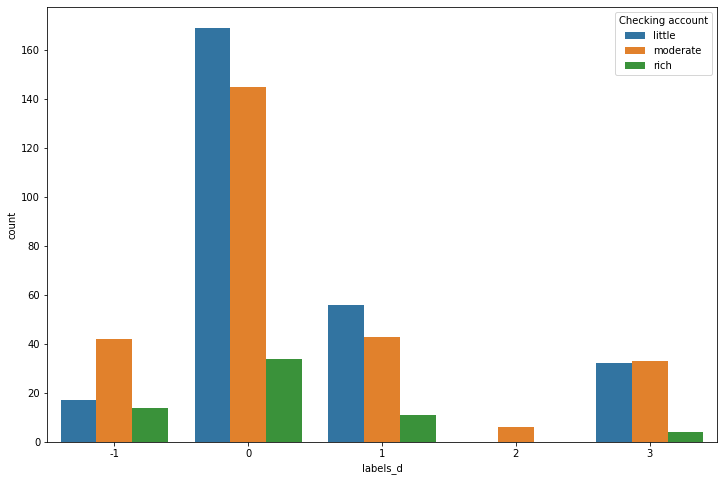

In [89]:
sns.countplot(data = data, x= 'labels_d', hue = 'Checking account')

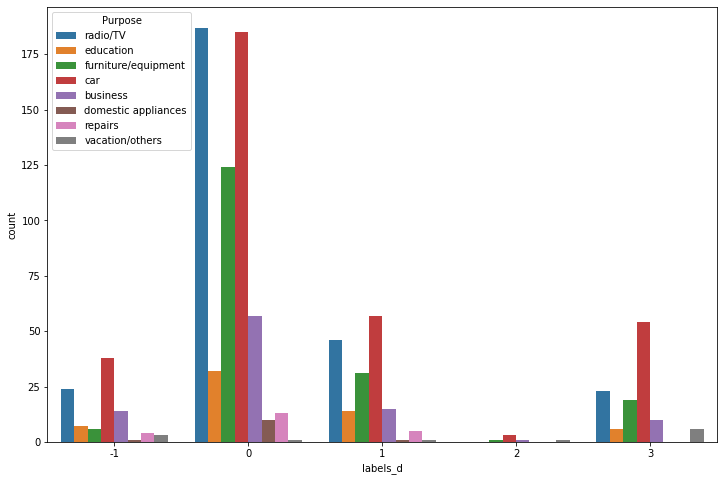

In [90]:
sns.countplot(data = data, x= 'labels_d', hue = 'Purpose')

In [91]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,labels_k,labels_a,labels_d
0,67,male,2,own,NaN,little,1169,6,radio/TV,2,0,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1,1,0
2,49,male,1,own,little,NaN,2096,12,education,2,0,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1,1,0
4,53,male,2,free,little,little,4870,24,car,2,1,0


In [92]:
data[data['labels_d'] == 2]

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,labels_k,labels_a,labels_d
7,35,male,3,rent,little,moderate,6948,36,car,1,2,2
99,36,male,3,rent,NaN,moderate,7057,20,car,1,2,2
154,36,male,3,rent,moderate,moderate,6967,24,business,1,2,2
287,31,male,3,free,moderate,moderate,7582,48,vacation/others,1,1,2
291,28,male,3,rent,little,moderate,9398,36,car,1,2,2
496,29,male,3,rent,moderate,moderate,9034,36,furniture/equipment,1,2,2


In [93]:
df.groupby('labels_d').mean().T.round(2)

labels_d,-1,0,1,2,3
Age,0.72,-0.13,0.02,-0.27,0.08
Job,-0.64,0.15,-1.38,1.68,1.68
Saving accounts,0.98,0.38,0.18,0.50,0.12
Checking account,0.72,0.35,0.38,1.00,0.35
Credit amount,0.18,-0.04,-0.46,1.51,0.67
Duration,0.43,0.00,-0.49,1.03,0.28
Purpose,0.23,0.24,0.24,0.22,0.25
Sex_male,0.52,0.70,0.71,1.00,0.76
Housing_own,0.53,0.73,0.80,0.00,0.67
Housing_rent,0.28,0.17,0.18,0.83,0.12


в нашем самом маленьком кластере  - мужчины с хорошей работой, высоким кредито, и дом - который в аренде



*   возраст - сложно проинтерпретировать, возрастная категория у наших кластеров +- 
*   пол - во втором маленьком кластере нет женгщин
*   Housing - в 0 кластере много клиентов с Housing free (видимо беспл жилье)
*   Saving accounts - все богатые сконцентрировалис в 0 кластере
*   Credit amount - 2 группа берет больше всего денег, следующая по рангу - 3 группа, причем в 3 группе много "бедных"
*   Duration - 2 группа берет кредит на больше всего месяцев, 3 группа бедных на 2ом месте
*   Цели - на первый взгляд распределены равномерно, учитывая неравномерность распределения целей

Итого можно охарактеризовать группы:

1 - с плохой работой (наибольшие риски)

2 - с хорошей работой, с хорошим счетом, долгим сроком погашения, и большой суммой кредита (похожа на группу 3)

3 - с хорошей работой

